# EDA - Team NLP's task

### Imports

In [137]:
import pandas as pd
pd.options.display.max_colwidth = 300
import seaborn as sns
from nltk.stem import PorterStemmer
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Deep Learning solution
from transformers import BertTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding, AutoConfig
from datasets import Dataset, load_metric
import wandb
wandb.login()


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

### Load the dataset and keep only necessary features - General dataset overview

In [138]:
df = pd.read_csv('action_enrichment_ds_home_exercise.csv')
df.head()

,EventName,Text,Action,Label
0,Jump Ball by Boston College Eagles,"And he's been talking about that to his team, you know, so they're not the usual standards that his teams have had, but their goals are within reach. Not referring to the announcers on the call.",NaN,0
1,J. Karnik missed Jumper.,This is James Karnik banging with Francisco Caffaro. And there's the rebounding from BECU talked about from TJ Bickerson.,NaN,0
2,2-pointer by Boston College Eagles,"One interesting note, they didn't double the post that time. That's normally a foregone conclusion with the Cavaliers, and the extra possession leads to a buck.",NaN,0
3,Missed Shot by Kihei Clark,"Well, over the last couple of months he's really elevated his game his sophomore campaign. Expect him to continue to ascend to be one of the better players in the ACC.",NaN,0
4,Dunk by T.J. Bickerstaff,"The ball in the hands of Makai Ashton. Langford is the top scorer for the Eagles, Bickerstaff on the baseline from Karnak.",NaN,0


In [139]:
df.describe()

,Label
count,2607.000000
mean,0.345224
std,0.475533
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [140]:
df.isna().sum()

EventName       0
Text           15
Action       1489
Label           0
dtype: int64

### __Text__

First let's check the null values in the ***Text*** feature.

Since the text is the core input of the input of our solution, since we don't have any reliable solution to impute those NaN values and since there are only 15 of them, we can remove those lines without any worries. Moreover those actions don't have any label and are not valid.

In [141]:
print(df[df['Text'].isna()])
df = df[df['Text'].notna()]

                                 EventName Text Action  Label
287                C. Braun missed Jumper.  NaN    NaN      0
554                   Foul on K. Chandler.  NaN    NaN      0
555            Turnover by Marcus Williams  NaN    NaN      0
556          Missed Shot by Wade Taylor IV  NaN    NaN      0
557            2-pointer by Tyrece Radford  NaN    NaN      0
558          3-pointer by Santiago Vescovi  NaN    NaN      0
559             Turnover by Wade Taylor IV  NaN    NaN      0
560           3-pointer by Quenton Jackson  NaN    NaN      0
562         Rebound by Josiah-Jordan James  NaN    NaN      0
564                   Foul on M. Williams.  NaN    NaN      0
565           2-pointer by Quenton Jackson  NaN    NaN      0
566   Quarter End by Tennessee Volunteers   NaN    NaN      0
877                Rebound by Sydney Curry  NaN    NaN      0
1196      Missed Shot by Jaden Shackelford  NaN    NaN      0
1336           Missed Shot by Andrew Jones  NaN    NaN      0


Now let's study the length (number of words) distribution of the ***Text***. For thar we gonna focus on the number of words.

In [142]:
df['Text_length'] = df['Text'].str.split().apply(len)

In [143]:
df['Text_length'].describe()

count    2592.000000
mean       18.088735
std        10.219316
min         1.000000
25%        10.000000
50%        17.000000
75%        25.000000
max        54.000000
Name: Text_length, dtype: float64

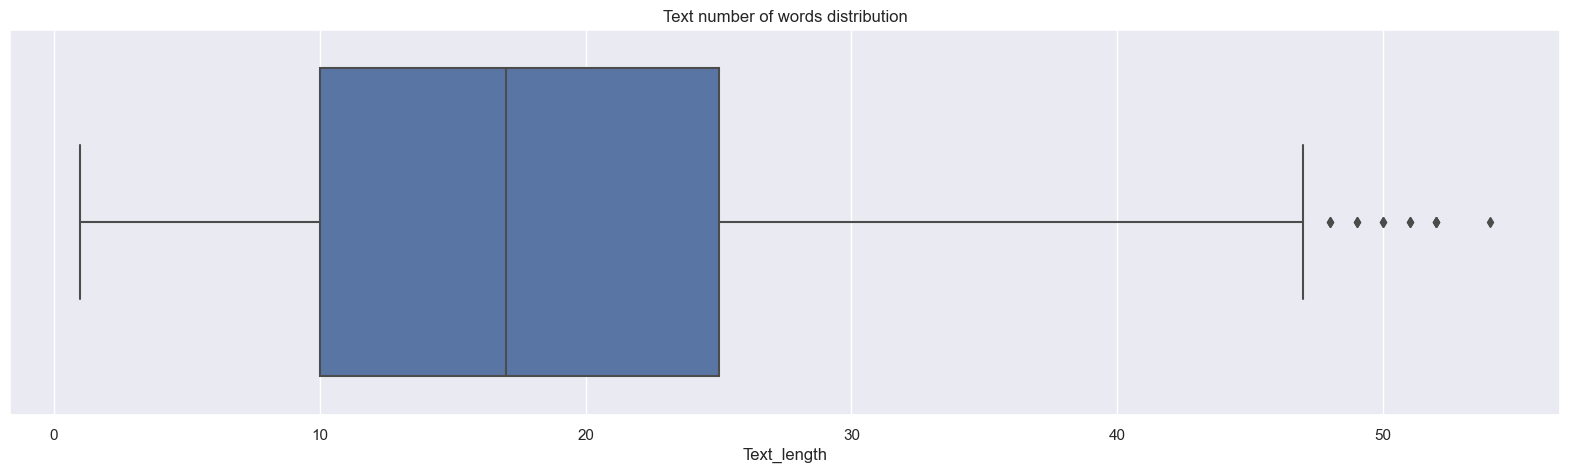

In [144]:
ax = sns.boxplot(x=df["Text_length"]).set(title='Text number of words distribution')

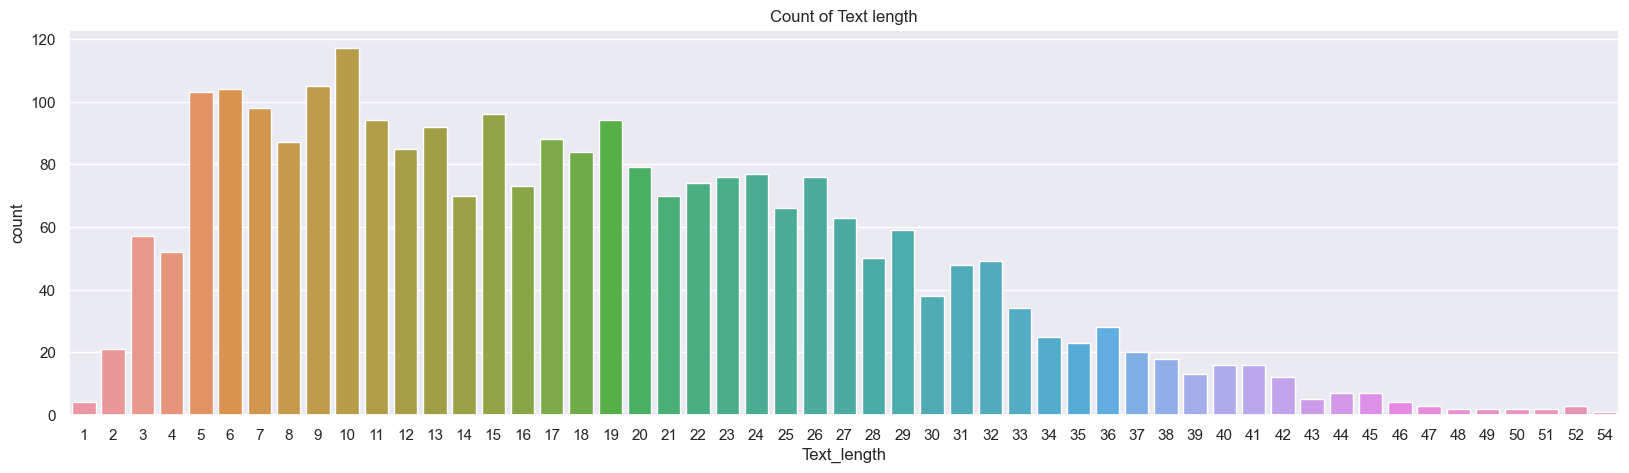

In [145]:
sns.set(rc={'figure.figsize':(20,5)})
ax = sns.countplot(x='Text_length', data=df).set(title='Count of Text length')

It looks like we have some Text with very few words. It might be useless noise for our solution. Let's investigate it.

In [146]:
df[df['Text_length'] <= 2]

,EventName,Text,Action,Label,Text_length
189,T. Martin missed Jumper.,Arden collects.,NaN,0,2
210,R. Nembhard missed Jumper.,Them hard.,NaN,0,2
221,T. Alexander missed Three Point Jumper.,Boy. Alexander.,NaN,0,2
563,Turnover by Tyrece Radford,Come on.,NaN,0,2
1213,Turnover by Andrew Jones,Loose. Mcculler.,NaN,0,2
1218,Foul on D. Batcho.,Mitchell.,NaN,0,1
1269,Foul by Devin Askew,Warren.,NaN,0,1
1278,Foul by Dylan Disu,Williams.,NaN,0,1
1314,Missed Shot by Kevin Obanor,Obanner.,NaN,0,1
1659,Missed Shot by Mike ConleyBlock by Andrew WigginsRebound by Jerryd Bayless,Conley's teardrop.,teardrop,1,2


Well, It seems like those specific comments are Names that are quoted or very shaort sentences. It's pretty common in collective sport to underline the action of 1 player. It is relevant data, <u>let's keep it</u>.

Now let's check if we have any duplicates ?

In [147]:
count = 0
for x in list(dict(Counter(df['Text'])).values()):
    if x > 1:
        count += 1
    else:
        count = 0
print(f'Number of Text duplicates in dataset : {count}')

Number of Text duplicates in dataset : 0


Now let's have an idea of the words distribution

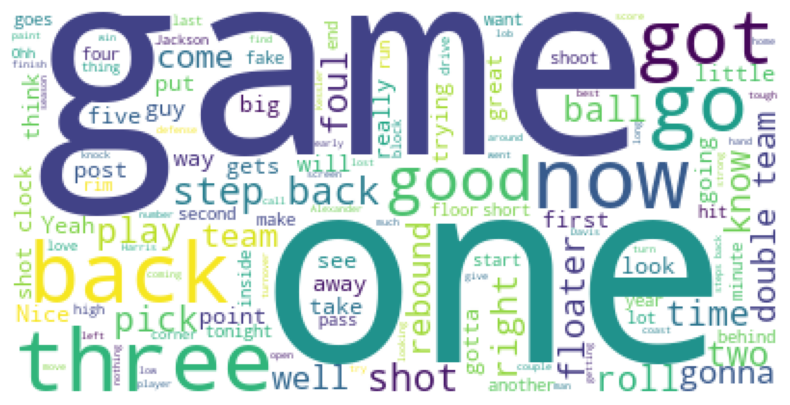

In [148]:
wc = WordCloud(background_color="white").generate(' '.join(df['Text']))
plt.axis("off")
plt.imshow(wc)
plt.show()

### Action

In [149]:
print(f'Number of NaN actions : {df["Action"].isna().sum()}')
print(f'proportion of NaN actions : {round(df["Action"].isna().sum() / len(df) * 100, 2)} %')

Number of NaN actions : 1474
proportion of NaN actions : 56.87 %


In [150]:
df[df["Action"].isna()]

,EventName,Text,Action,Label,Text_length
0,Jump Ball by Boston College Eagles,"And he's been talking about that to his team, you know, so they're not the usual standards that his teams have had, but their goals are within reach. Not referring to the announcers on the call.",NaN,0,36
1,J. Karnik missed Jumper.,This is James Karnik banging with Francisco Caffaro. And there's the rebounding from BECU talked about from TJ Bickerson.,NaN,0,19
2,2-pointer by Boston College Eagles,"One interesting note, they didn't double the post that time. That's normally a foregone conclusion with the Cavaliers, and the extra possession leads to a buck.",NaN,0,26
3,Missed Shot by Kihei Clark,"Well, over the last couple of months he's really elevated his game his sophomore campaign. Expect him to continue to ascend to be one of the better players in the ACC.",NaN,0,31
4,Dunk by T.J. Bickerstaff,"The ball in the hands of Makai Ashton. Langford is the top scorer for the Eagles, Bickerstaff on the baseline from Karnak.",NaN,0,22
...,...,...,...,...,...
1484,Foul by Montez Mathis,"It's Durham to inbound, over to Maniac, who will now try to get it in back to Durham. Nicely done by the Friars. And there's the foul by Mathis.",NaN,0,29
1485,Foul by Aaron Wheeler,"Chance does not have a time out, but Naah gets it into Durham. You gotta fight, yeah, and he holds it and killed a couple of seconds.",NaN,0,27
1486,2-pointer by Posh Alexander,Make them use time. Alexander with eight seconds left. He'll drive and he lays it in 4.8 on the clock.,NaN,0,20
1487,Foul by Tareq Coburn,Port clerk quickly into Durham. There's the foul with 3.8 remaining.,NaN,0,11


Let's fill NaN value with 'None' as it will be our *empty* category for later modelization

In [151]:
df['Action'] = df['Action'].fillna('no_action')
df["Action"].value_counts()

Action
no_action              1474
step back               198
floater                 140
doubl team              112
pick and roll           101
fake                     93
post up                  81
lob                      42
backdoor                 35
behind the back          30
alley oop                25
finger roll              24
coast to coast           22
jam                      22
tip in                   21
pump fake                19
fadeaway                 18
splash                   14
slam dunk                13
noth but net             13
teardrop                 11
euro step                 9
bank shot                 8
outlet pass               8
no look pass              7
dime                      7
between the leg           5
flop                      5
take it to the rack       5
poster                    5
jab step                  5
swish                     4
give and go               4
basebal pass              3
side step                 3
rainbow shot 

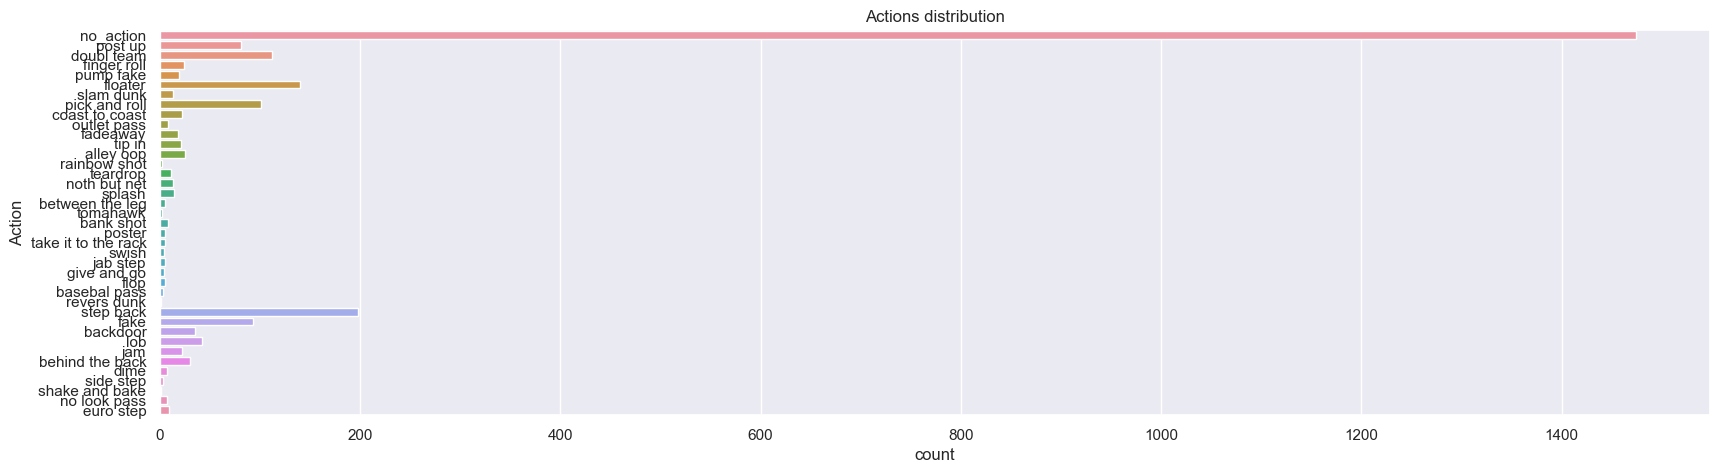

In [152]:
ax = sns.countplot(y='Action', data=df).set(title='Actions distribution')

With the previous metrics, we can see that the actions are heavily inbalanced in the dataset. With the 'no_action' as the mode of the distribution

### Label

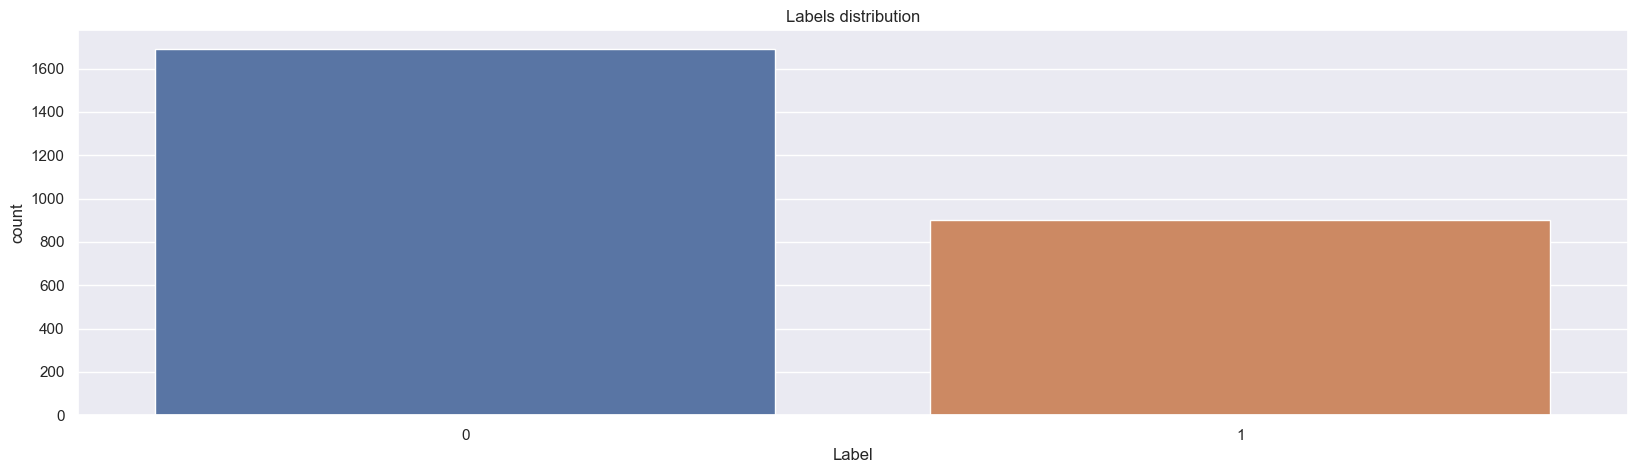

In [153]:
ax = sns.countplot(x='Label', data=df).set(title='Labels distribution')

The different types of label are also inbalanced in the dataset

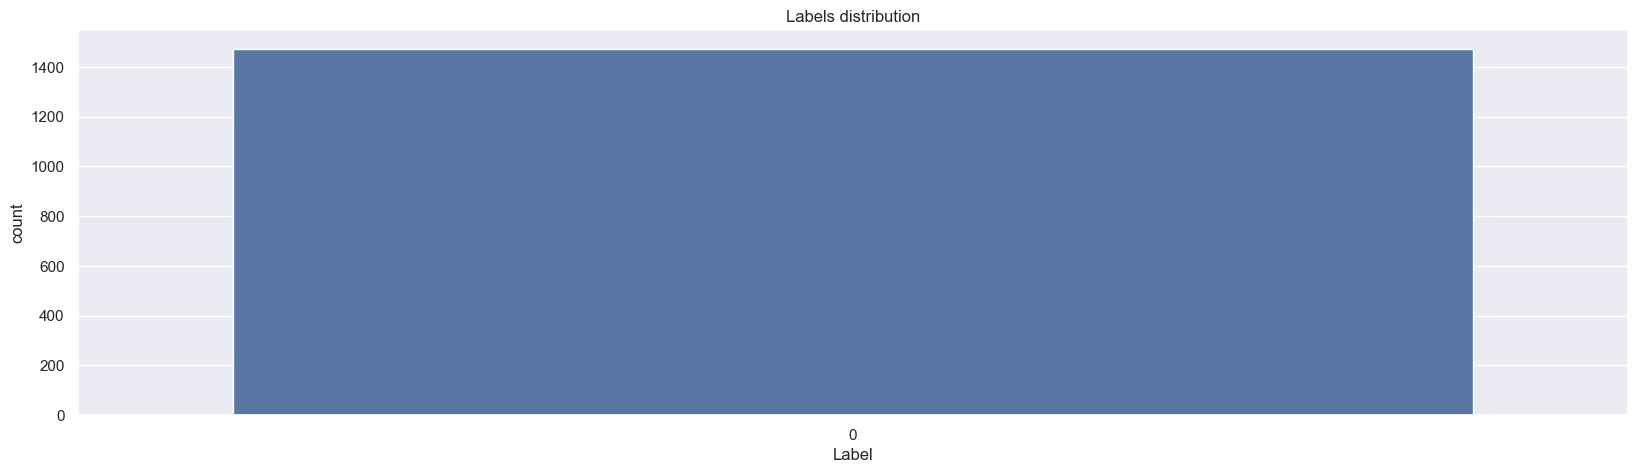

In [154]:
ax = sns.countplot(x='Label', data=df[df['Action'] == 'no_action']).set(title='Labels distribution')

All the 'no_action' actions are non valid

In [155]:
df2 = df.query("Label == 1").sample(n=600)
df = pd.concat([df,df2])

# Solution

Let's dive into the solution and split our strategy in 2 parts :
- Find a good way to identify the action
- Find a good way to identify if the text is valid

### Solution - Action

Let's take an intuitive approach for this task. We already have a list of actions. Let's try if the text contains the action.

In [156]:
actions = list(df['Action'].unique())
df['Text_lower'] = df['Text'].str.lower()

In [157]:
actions

['no_action',
 'post up',
 'doubl team',
 'finger roll',
 'pump fake',
 'floater',
 'slam dunk',
 'pick and roll',
 'coast to coast',
 'outlet pass',
 'fadeaway',
 'tip in',
 'alley oop',
 'rainbow shot',
 'teardrop',
 'noth but net',
 'splash',
 'between the leg',
 'tomahawk',
 'bank shot',
 'poster',
 'take it to the rack',
 'swish',
 'jab step',
 'give and go',
 'flop',
 'basebal pass',
 'revers dunk',
 'step back',
 'fake',
 'backdoor',
 'lob',
 'jam',
 'behind the back',
 'dime',
 'side step',
 'shake and bake',
 'no look pass',
 'euro step']

We can see that the actions are stemmed. For instance *basebal* or *revers*. Let's apply stemming to the text to see if we can fin the exact action in the text.

In [158]:
ps = PorterStemmer()

def stemming(initial_sentence: str) -> str:
    initial_sentence_list = initial_sentence.split(' ')
    stem_list = []
    for token in initial_sentence_list:
        stem_list.append(ps.stem(token))
    new_sentence = ' '.join(stem_list)
    return new_sentence
df['Text_stem'] = df['Text_lower'].apply(stemming)

In [159]:
df['difference_stem'] = df.apply(lambda x: x['Action'] if x['Action'] in x['Text_stem'] else 'no_action', axis=1)
df['Action'].isin(df.difference_stem).sum()

3192

For inference, we will just have to apply stemming to the input and check if one of the action in is present in it 😉.

In [ ]:
# Saving the model
df.to_pickle('./data/data.pkl')

### Solution - Validity

As we don't have any specific reason of the validity. Let's think about a solution that can find the relation between the text and the validity by itself.

The number on solution for this kind of classification problematic is to build a Neural Netword. Let's used advanced solution that are already pre-trained like Bert

The solution for solving validity is in the *fineutune.py* and *finetuner.py* files

In [25]:
ds = Dataset.from_pandas(df[['Text_lower', 'Label']])
ds = ds.train_test_split(test_size=0.2, shuffle=True)
ds = ds.rename_columns({'Text_lower': 'text', 'Label':'label'})

In [26]:
model = "distilbert-base-uncased-finetuned-sst-2-english"

In [27]:
tokenizer = BertTokenizer.from_pretrained(model)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


In [28]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)
tokenized_datasets = ds.map(tokenize_function, batched=True)

In [29]:
AutoConfig.from_pretrained(model)

DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased-finetuned-sst-2-english",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "finetuning_task": "sst-2",
  "hidden_dim": 3072,
  "id2label": {
    "0": "NEGATIVE",
    "1": "POSITIVE"
  },
  "initializer_range": 0.02,
  "label2id": {
    "NEGATIVE": 0,
    "POSITIVE": 1
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.30.2",
  "vocab_size": 30522
}

In [30]:
model = AutoModelForSequenceClassification.from_pretrained(model, num_labels=2)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [31]:
import numpy as np
accuracy_metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    # metrics from the datasets library have a compute method
    return accuracy_metric.compute(predictions=predictions, references=labels)

/var/folders/07/t074yt992z94js550nmsd3rc0000gn/T/ipykernel_36847/2790040644.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy_metric = load_metric("accuracy")


In [32]:
training_args = TrainingArguments(
    output_dir="./results",
    use_mps_device=True,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    report_to="wandb",
    evaluation_strategy='steps',
    logging_steps=100,
    eval_steps=50,
    save_steps=50,
    eval_accumulation_steps=1,
    load_best_model_at_end=True,
    metric_for_best_model="loss",
    run_name='floater-dunk'
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)


trainer.train()

/opt/anaconda3/envs/wcs/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


                                                
 10%|█         | 50/480 [00:46<05:19,  1.34it/s]

{'eval_loss': 0.41722410917282104, 'eval_accuracy': 0.8341158059467919, 'eval_runtime': 9.2851, 'eval_samples_per_second': 68.82, 'eval_steps_per_second': 4.308, 'epoch': 0.31}


 21%|██        | 100/480 [01:25<04:49,  1.31it/s]

{'loss': 0.6199, 'learning_rate': 1.5833333333333333e-05, 'epoch': 0.62}


                                                 
 21%|██        | 100/480 [01:35<04:49,  1.31it/s]

{'eval_loss': 0.26236850023269653, 'eval_accuracy': 0.8857589984350548, 'eval_runtime': 9.498, 'eval_samples_per_second': 67.278, 'eval_steps_per_second': 4.211, 'epoch': 0.62}


                                                 
 31%|███▏      | 150/480 [02:23<04:09,  1.32it/s]

{'eval_loss': 0.2671104669570923, 'eval_accuracy': 0.892018779342723, 'eval_runtime': 9.5097, 'eval_samples_per_second': 67.195, 'eval_steps_per_second': 4.206, 'epoch': 0.94}


 42%|████▏     | 200/480 [03:02<03:31,  1.33it/s]

{'loss': 0.2299, 'learning_rate': 1.1666666666666668e-05, 'epoch': 1.25}


                                                 
 42%|████▏     | 200/480 [03:11<03:31,  1.33it/s]

{'eval_loss': 0.2050483673810959, 'eval_accuracy': 0.918622848200313, 'eval_runtime': 9.6099, 'eval_samples_per_second': 66.494, 'eval_steps_per_second': 4.162, 'epoch': 1.25}


                                                 
 52%|█████▏    | 250/480 [03:59<02:53,  1.33it/s]

{'eval_loss': 0.21361012756824493, 'eval_accuracy': 0.9233176838810642, 'eval_runtime': 9.1492, 'eval_samples_per_second': 69.842, 'eval_steps_per_second': 4.372, 'epoch': 1.56}


 62%|██████▎   | 300/480 [04:38<02:15,  1.33it/s]

{'loss': 0.1728, 'learning_rate': 7.500000000000001e-06, 'epoch': 1.88}


                                                 
 62%|██████▎   | 300/480 [04:47<02:15,  1.33it/s]

{'eval_loss': 0.2169162482023239, 'eval_accuracy': 0.92018779342723, 'eval_runtime': 9.2149, 'eval_samples_per_second': 69.345, 'eval_steps_per_second': 4.341, 'epoch': 1.88}


                                                 
 73%|███████▎  | 350/480 [05:35<01:36,  1.34it/s]

{'eval_loss': 0.1868557184934616, 'eval_accuracy': 0.9327073552425665, 'eval_runtime': 9.1664, 'eval_samples_per_second': 69.711, 'eval_steps_per_second': 4.364, 'epoch': 2.19}


 83%|████████▎ | 400/480 [06:13<01:00,  1.32it/s]

{'loss': 0.1211, 'learning_rate': 3.3333333333333333e-06, 'epoch': 2.5}


                                                 
 83%|████████▎ | 400/480 [06:22<01:00,  1.32it/s]

{'eval_loss': 0.21667920053005219, 'eval_accuracy': 0.9342723004694836, 'eval_runtime': 9.0684, 'eval_samples_per_second': 70.465, 'eval_steps_per_second': 4.411, 'epoch': 2.5}


                                                 
 94%|█████████▍| 450/480 [07:10<00:22,  1.36it/s]

{'eval_loss': 0.21771731972694397, 'eval_accuracy': 0.9374021909233177, 'eval_runtime': 9.2759, 'eval_samples_per_second': 68.888, 'eval_steps_per_second': 4.312, 'epoch': 2.81}


100%|██████████| 480/480 [07:34<00:00,  1.06it/s]

{'train_runtime': 458.4829, 'train_samples_per_second': 16.705, 'train_steps_per_second': 1.047, 'train_loss': 0.2542385905981064, 'epoch': 3.0}


TrainOutput(global_step=480, training_loss=0.2542385905981064, metrics={'train_runtime': 458.4829, 'train_samples_per_second': 16.705, 'train_steps_per_second': 1.047, 'train_loss': 0.2542385905981064, 'epoch': 3.0})

In [33]:
trainer.evaluate()

100%|██████████| 40/40 [00:07<00:00,  5.17it/s]


{'eval_loss': 0.1868557184934616,
 'eval_accuracy': 0.9327073552425665,
 'eval_runtime': 8.1921,
 'eval_samples_per_second': 78.002,
 'eval_steps_per_second': 4.883,
 'epoch': 3.0}

In [ ]:
preds = trainer.predict(tokenized_datasets['test'])

In [35]:
y_true = tokenized_datasets['test'].to_dict()['label'] 

In [36]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true, np.argmax(preds.predictions, axis=1))

0.9327073552425665

In [37]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(preds.predictions, axis=1)).ravel()
(tn, fp, fn, tp)

(326, 28, 15, 270)

In [45]:
text = ['what a lob !']
to_pred = tokenizer(text, padding="max_length", truncation=True)

In [80]:
text = "He lob over wemby"
to_predict = {'text': [text]}
ds = Dataset.from_dict(to_predict)
to_predict_token = ds.map(tokenize_function)
np.argmax(trainer.predict(to_predict_token).predictions)

100%|██████████| 1/1 [00:00<00:00, 976.56it/s]   


1

In [103]:
path = './model'
trainer.save_model(path)

In [136]:
model_frompath = AutoModelForSequenceClassification.from_pretrained(path)
inputs = tokenizer("Yesterday he marked a dunk", return_token_type_ids=False, return_tensors='pt')
with torch.no_grad():
    logits = model_frompath(**inputs).logits

np.argmax(list(logits))

0